# Classificació de gestos

## Introducció

En aquesta pràctica buscarem el millor model de classificació que donades lectures de diferents sensors pugui classificar a quina clase de gest pertany. Tindrem 4 diferents gestos: pedra, tisores, paper i ok; i tindrem també 8 sensors dels quals farem 8 lectures per cada un d'ells.

Començarem per analitzar les dades i les relacions entre elles, aplicarem les modificacions a les dades, posteriorment buscarem el millor model i buscarem els millors hiperparàmetres pel model seleccionat.

## Anàlisi de dades

Primer observarem les dades que tenim, com són. Abans de començar cal tenir en compte que ja s'ha fet una transformació de les dades, s'ha passat de les dades categòriques: pedra, tisores, paper i ok, a les dades: 0, 1, 2 i 3 respectivament. 

Així, com també analitzarem la quantitat de variables nules i també el tipus de dades i les estadístiques que tenim en el nostre conjunt de dades del dataset, .


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc, classification_report, accuracy_score, make_scorer


def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset = load_dataset('../data/dades.csv')

data = dataset.values

print(dataset.head())

   Lect1-Sen1  Lect1-Sen2  Lect1-Sen3  Lect1-Sen4  Lect1-Sen5  Lect1-Sen6  \
0         260          40          50          80         -10        -130   
1        -470         -60         -50         -70         130         -10   
2        -190         -80         -80         -80        -210         -60   
3          20          30           0          20           0         220   
4          60           0           0         -20        -140         100   

   Lect1-Sen7  Lect1-Sen8  Lect2-Sen1  Lect2-Sen2  ...  Lect7-Sen8  \
0       -1090        -660         -90          20  ...        -280   
1         350        -100         100         -40  ...        -250   
2        -790         120           0          50  ...        -830   
3        1060        -140        -160         -20  ...        -380   
4        -510          50          70           0  ...         380   

   Lect8-Sen1  Lect8-Sen2  Lect8-Sen3  Lect8-Sen4  Lect8-Sen5  Lect8-Sen6  \
0         610          40          80  

In [2]:
def print_data_types(dataset):
    print("------------------------------------")
    print("Tipus de dades")
    print(dataset.dtypes)
    print("------------------------------------")

print_data_types(dataset)

def nan(dataset):
    print("Numero 'NaNs' del DataFrame")
    print(dataset.isnull().sum().sum())
    print("------------------------------------")

nan(dataset)

------------------------------------
Tipus de dades
Lect1-Sen1    int64
Lect1-Sen2    int64
Lect1-Sen3    int64
Lect1-Sen4    int64
Lect1-Sen5    int64
              ...  
Lect8-Sen5    int64
Lect8-Sen6    int64
Lect8-Sen7    int64
Lect8-Sen8    int64
Forma         int64
Length: 65, dtype: object
------------------------------------
Eliminació 'NaN' del DataFrame
0
------------------------------------




Posteriorment analitzarem les distribucions dels atributs i correlacions, tan dels diferents atributs, com dels diferents atributs segons la classe a la que pertanyen. La correlació de Pearson en els casos de classificació no resulta molt rellevant, en el nostre cas no hi ha correlació entre els diferents atributs. 
Els histogrames ens permetràn veure si els atributs segueixen distribució normal, la qual cosa facilitarà el seu ús, podem dibuixar els histogrames per cada atribut i també els histogrames per cada atributs segons la classe a la que pertanyen.

<Figure size 432x288 with 0 Axes>

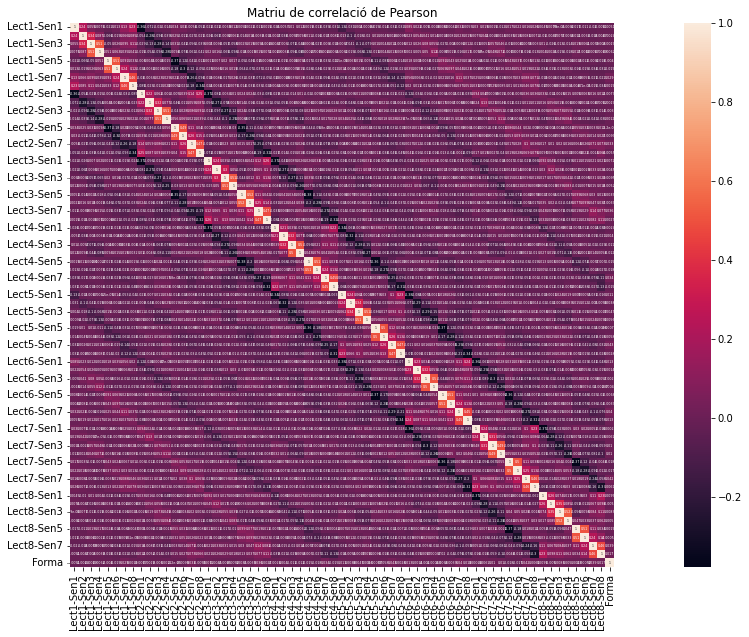

In [3]:
plt.figure()
fig, ax = plt.subplots(figsize=(25, 10)) 

plt.title("Matriu de correlació de Pearson")
sns.heatmap(dataset.corr(), annot=True, ax=ax, linewidths=.0, annot_kws={"fontsize": 350 / np.sqrt(len(dataset))},square=True)

plt.show()

La distribució de les classes de sortida és molt important, en el nostre cas veiem que és uniforme.

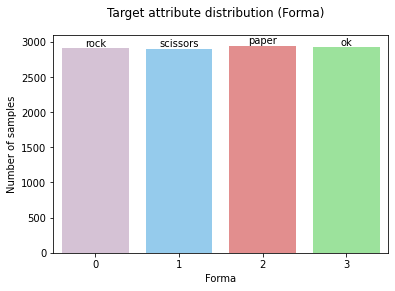

In [5]:
plt.figure()
ax = sns.countplot(x="Forma", data=dataset,
                       palette={0: 'thistle', 1: "lightskyblue", 2: "lightcoral", 3: "lightgreen"})
plt.suptitle("Target attribute distribution (Forma)")
label = ["rock", "scissors", "paper", "ok"]
ax.bar_label(container=ax.containers[0], labels=label)
plt.xlabel('Forma')
plt.ylabel('Number of samples')
plt.show()

## Models provats

Hem provat molts models amb diferents K de validació creuada, en aquesta taula ens centrarem amb K=6. En la tuala hi ha també les proves corresponents a transformacions en les dades com Polynomial Features i PCA i també els resultats després d ebuscar els millors hiperparàmetres pels algoritmes.

In [7]:
taula=pd.DataFrame(data=[[0.818036,0.817371,0.818415,0.977119,17.85867],
                         [0.245589,0.098570,0.250000,0.553467,41.518445],
                         [0.920020,0.919824,0.920368,0.989928,69.864293],
                         [0.323345,0.326469,0.324647,0.544512,19.949933],
                         [0.345520,0.348176,0.346437,0.546157,2.845808],
                         [0.883970,0.882988,0.883994,0.977816,0.012689],
                         [0.344493,0.350439,0.345860,0.548556,0.144664],
                         [0.778987,0.779233,0.779025,0.852674,0.461008],
                         [0.670663,0.635766,0.672178,0.867733,0.007477],
                         [0.942284,0.942037,0.942457,0.992936,1.334993],
                         [0.919850,0.919503,0.919884,0.989013,1.719924],
                         [0.963179,0.963169,0.963230,0.996915,2.654746],
                         [0.867359,0.867808,0.867364,0.851359,3.41254],
                         [0.886881,0.885997,0.886962,0.977714,0.092911],
                         [0.952561,0.952558,0.952631,0.995300,36.293592],
                         [0.512655,0.455249,0.514618,0.743138,70.429025],
                         [0.279842,0.197285,0.282339,0.55691,13.949179],
                         [0.35237,0.32555,0.353552,0.620322,0.00261],
                         [0.323001,0.322046,0.32345,0.589437,0.503085],
                         [0.321801,0.321087,0.321956,0.587617,0.757956],
                         [0.337557,0.332068,0.338396,0.59776,1.185864],
                         [0.35357,0.345593,0.354558,0.618729,5.662057],
                         [0.916595,0.916489,0.916887,0.98939,61.240561],
                         [0.657474,0.649311,0.657644,0.883002,0.010552],
                         [0.838156,0.835965,0.837912,0.955344,1.38638],
                         [0.82814,0.8263,0.8282,0.954558,3.247407],
                         [0.917879,0.917967,0.918066,0.989149,3.151961],
                         [0.857082,0.857022,0.857143,0.971555,91.218569],
                         [0.908631,0.908338,0.908906,0.984461,158.23523],
                         [0.793373,0.790607,0.793639,0.908139,0.426783],
                         [0.936375,0.936015,0.936479,0.991262,12.072105],
                         [0.928755,0.928452,0.92889,0.990743,17.806048],
                         [0.966176,0.966209,0.966331,0.997548,108.075791],
                         [0.945453,0.945376,0.945477,0.993871,682.145916],
                         [0.932781,0.932602,0.932886,0.991979,6.638652],
                         [0.931153,0.930847,0.931232,0.991769,3.949915],
                         [0.965920,0.965942,0.966006,0.997287,3.328895],
                         [0.948022,0.947792,0.948039,0.993981,2.048845],
                         [0.955558,0.955561,0.955633,0.995980,50.80007]],
                   columns=['Accuracy', 'F1_score', 'Recall', 'Roc', ' Time'] , 
                   index=['SVM rbf','SVM sigmoide','SVM polinomi','SVM linear','Logístic','Gaussian Naive Bayes','Linear Discrminants Analysis','Decision Tree','KNN','Extra Trees','Random Forest','HistGradientBoosting','AdaBoosting','Bagging','GradientBoosting','Xarxa Neuronal MLPC','SVM polinomi (pca=mle)','Gaussian Naive Bayes (pca=mle)','Extra Trees (pca=mle)','Random Forest (pca=mle)','HistGradientBoosting (pca=mle)','GradientBoosting (pca=mle)','SVM polinomi gamma=0.9 (pca=3)','Gaussian Naive Bayes (pca=3)','Extra Trees (pca=3)','Random Forest (pca=3)','HistGradientBoosting (pca=3)','GradientBoosting (pca=3)','SVM polinomi gamma=0.9 (polinomi)','Gaussian Naive Bayes (polinomi)','Extra Trees (polinomi)','Random Forest (polinomi)','HistGradientBoosting (polinomi)','GradientBoosting (polinomi)','Optimitzat Random Forest 1','Optimitzat Random Forest 2','Optimitzat HistGradientBoosting','Optimitzat Extra Trees','Optimitzat GradientBoosting'])

taula

,Accuracy,F1_score,Recall,Roc,Time
SVM rbf,0.818036,0.817371,0.818415,0.977119,17.858670
SVM sigmoide,0.245589,0.098570,0.250000,0.553467,41.518445
SVM polinomi,0.920020,0.919824,0.920368,0.989928,69.864293
SVM linear,0.323345,0.326469,0.324647,0.544512,19.949933
Logístic,0.345520,0.348176,0.346437,0.546157,2.845808
Gaussian Naive Bayes,0.883970,0.882988,0.883994,0.977816,0.012689
Linear Discrminants Analysis,0.344493,0.350439,0.345860,0.548556,0.144664
Decision Tree,0.778987,0.779233,0.779025,0.852674,0.461008
KNN,0.670663,0.635766,0.672178,0.867733,0.007477
Extra Trees,0.942284,0.942037,0.942457,0.992936,1.334993


## Model seleccionat

Veient els resultats triarem el Hist Gradient Boosting com a model, un cop fet la cerca dels millors hiperparàmetres

In [25]:

data = dataset.values
x = data[:, :64]
y = data[:, 64]

Xtrain, Xtest, ytrain, ytest = train_test_split(x, y)
clf=HistGradientBoostingClassifier( learning_rate=0.3, max_depth=430, max_iter=357, max_leaf_nodes=26, random_state=69)
clf.fit(Xtrain, ytrain)




probs = clf.predict_proba(Xtest)
predict=clf.predict(Xtest)











## ANALISI DE RESULTATS

## Corbes Precision_recall i ROC

0.9681506849315068


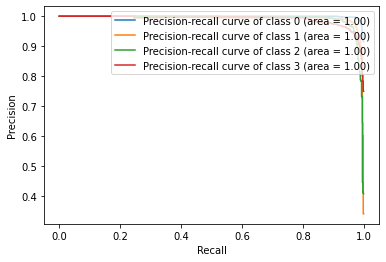

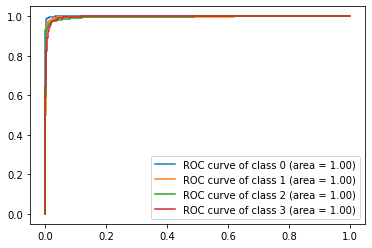

In [26]:

print(clf.score(Xtest,ytest))
# Corba precision recall
precision = {}
recall = {}
average_precision = {}
plt.figure()
n_classes=4
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ytest == i, probs[:, i])
    average_precision[i] = average_precision_score(ytest == i, probs[:, i])

    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, round(average_precision[i])))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

plt.show()
#corba ROC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

plt.show()






### Matriu de Confusió

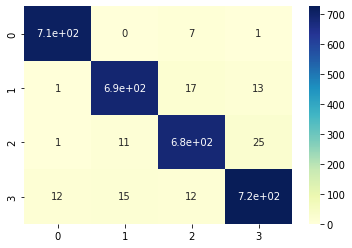

In [23]:

cf_m=confusion_matrix(ytest, predict)
plt.figure()
sns.heatmap(cf_m, annot=True, cmap="YlGnBu")

plt.show()

## Conclusions

Podem veure que hem obtingut un 96.8% d'accuracy amb el model seleccionat "Hist Gradient Boosting", la qual cosa es una molt bona accuracy, a més si observem la resta de característiques f1_score, recall i roc veiem que també ofereix molt bones característiques. Hi ha un algoritme GradientBoosting que dona una accuracy molt similar pero un temps molt major, és important que un model no tardi molt, perque si ha de processar moltes dades no funcionarà bé.

Per futurs treballs s'hauria de centrar en millorar les classificacions de la clase 2 i 3, per això estaria bé per exemple afegir un classificador al final entre les classes 2 i 3 que es on es cometen més errors i així millorar les prestacions.